In [3]:
import importlib
!pip install torchvision
!pip install pydub

In [42]:
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from pydub import AudioSegment
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.optim as optim

In [89]:
# Local imports
from data_utils import get_data, process_data_frame
from utils import load_protocol, plot_results
import train_utils

In [9]:
dataset_path = get_data()

In [12]:
# Load the .flac file
example_file = f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1004407.flac"
audio = AudioSegment.from_file(example_file, format="flac")

audio

In [17]:
def audio_to_mel_spectrogram(audio_path, n_fft=400, hop_length=160, n_mels=64):
    """
    Convert an audio file to a mel-spectrogram using librosa.
    Args:
        audio_path (str): Path to the audio file.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of mel filterbanks.
    Returns:
        np.ndarray: Mel-spectrogram as a numpy array.
    """
    # Load audio file
    waveform, sample_rate = librosa.load(audio_path, sr=None)

    # Generate mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize to [0, 1]
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.min()) / (log_mel_spectrogram.max() - log_mel_spectrogram.min())

    return log_mel_spectrogram

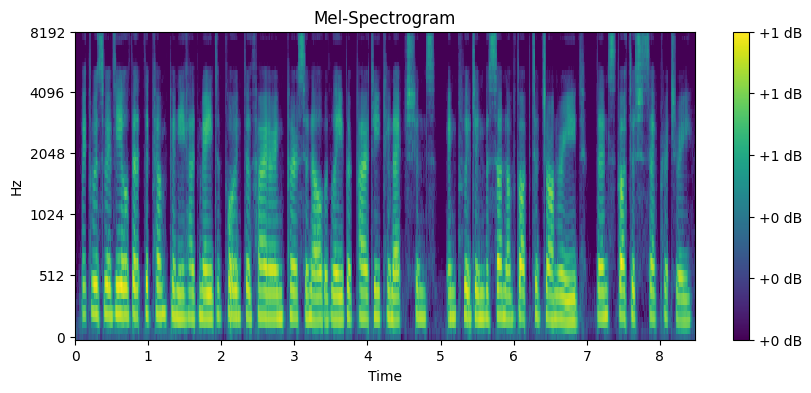

In [18]:
# Example usage
mel_spectrogram = audio_to_mel_spectrogram(example_file)

# Visualize the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=16000, hop_length=160, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.show()

In [101]:
col_names = ['speaker', 'file_name', 'attack', 'label']
protocols_folder = "LA/LA/ASVspoof2019_LA_cm_protocols"
protocol_file_prefix = "ASVspoof2019.LA.cm"
data_info_train_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.train.trn.txt"
data_info_val_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.dev.trl.txt"
data_info_test_file_path = f"{dataset_path}/{protocols_folder}/{protocol_file_prefix}.eval.trl.txt"

train_df_info = load_protocol(data_info_train_file_path, names=col_names)
val_df_info = load_protocol(data_info_train_file_path, names=col_names)
test_df_info = load_protocol(data_info_train_file_path, names=col_names)

In [102]:
print("Train dataset info:")
print(train_df_info.head())
print('-' * 40)
print("Val dataset info:")
print(val_df_info.head())
print('-' * 40)
print("Test dataset info:")
print(test_df_info.head())

Train dataset info:
   speaker     file_name attack     label
0  LA_0079  LA_T_1138215      -  bonafide
1  LA_0079  LA_T_1271820      -  bonafide
2  LA_0079  LA_T_1272637      -  bonafide
3  LA_0079  LA_T_1276960      -  bonafide
4  LA_0079  LA_T_1341447      -  bonafide
----------------------------------------
Val dataset info:
   speaker     file_name attack     label
0  LA_0079  LA_T_1138215      -  bonafide
1  LA_0079  LA_T_1271820      -  bonafide
2  LA_0079  LA_T_1272637      -  bonafide
3  LA_0079  LA_T_1276960      -  bonafide
4  LA_0079  LA_T_1341447      -  bonafide
----------------------------------------
Test dataset info:
   speaker     file_name attack     label
0  LA_0079  LA_T_1138215      -  bonafide
1  LA_0079  LA_T_1271820      -  bonafide
2  LA_0079  LA_T_1272637      -  bonafide
3  LA_0079  LA_T_1276960      -  bonafide
4  LA_0079  LA_T_1341447      -  bonafide


In [112]:
train_df = process_data_frame(train_df_info)
val_df = process_data_frame(val_df_info)
test_df = process_data_frame(test_df_info)

      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0
      file_name label
0  LA_T_1138215     0
1  LA_T_1271820     0
2  LA_T_1272637     0
3  LA_T_1276960     0
4  LA_T_1341447     0


In [32]:
def resize_spectrogram(spectrogram, fixed_time_steps=192):
    """
    Resize the spectrogram to a fixed time dimension using interpolation.
    Args:
        spectrogram (np.ndarray): Input spectrogram of shape (n_mels, time_steps).
        fixed_time_steps (int): Desired time dimension.
    Returns:
        np.ndarray: Resized spectrogram with shape (n_mels, fixed_time_steps).
    """
    n_mels, time_steps = spectrogram.shape

    # Calculate the zoom factor for the time dimension
    zoom_factor = (1, fixed_time_steps / time_steps)

    # Resize the spectrogram using interpolation
    resized_spectrogram = zoom(spectrogram, zoom_factor)

    return resized_spectrogram

In [52]:
class ASVSpoofDataset(Dataset):
    def __init__(self, audio_dir, data_info_df, fixed_time_steps=192):
        """
        Args:
            audio_dir (str): Directory with all the audio files.
        """
        self.audio_dir = audio_dir
        self.audio_files = os.listdir(audio_dir)
        self.data_info_df = data_info_df
        self.fixed_time_steps = fixed_time_steps

    def __len__(self):
        return min(len(self.data_info_df), len(self.audio_files))

    def __getitem__(self, idx):
        current_audio_path = os.path.join(self.audio_dir, self.audio_files[idx])
        spectrogram = audio_to_mel_spectrogram(current_audio_path)
        
        # Resize the spectrogram
        mel_spectrogram = resize_spectrogram(spectrogram, self.fixed_time_steps)

        # Convert to tensor and add channel dimension
        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)

        # Get label (0 for real, 1 for spoofed)
        label = self.data_info_df.iloc[idx]['label']

        return mel_spectrogram, float(label)

In [35]:
BATCH_SIZE = 32

In [94]:
# Example usage
train_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_train/flac"
val_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_dev/flac"
test_dir = f"{dataset_path}/LA/LA/ASVspoof2019_LA_eval/flac"

train_dataset = ASVSpoofDataset(train_dir, train_df)
val_dataset = ASVSpoofDataset(val_dir, val_df)
test_dataset = ASVSpoofDataset(test_dir, test_df)

In [50]:
print(f"Example of train dataset value - shape: {train_dataset[0][0].shape}, label: {train_dataset[0][1]}")
print('-' * 75)
print(f"Example of val dataset value - shape: {val_dataset[0][0].shape}, label: {val_dataset[0][1]}")

Example of train dataset value - shape: torch.Size([1, 64, 192]), label: 0.0
---------------------------------------------------------------------------
Example of val dataset value - shape: torch.Size([1, 64, 192]), label: 0.0


In [105]:
def initialize_model():# Load ResNet18 with pretrained weights
    resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # Modify the first layer to accept 1-channel input
    resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify the final layer for binary classification
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)
    
    # Add a sigmoid activation for binary output
    resnet18 = nn.Sequential(resnet18, nn.Sigmoid())
    
    return resnet18


In [84]:
# Long training on different hyperparameter combinations 
importlib.reload(train_utils)
criterion = nn.BCELoss()

# Define hyperparameter grid
param_grid = {
    'batch_size': [64, 128, 256],
    'learning_rate': [0.0001, 0.01],
    'epochs': [2, 6],
    'optimizer': ['Adam', 'RMSprop']
}

# Map optimizer names to their corresponding PyTorch classes
optimizer_map = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}

# Device setup
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Chosen device: {device}")

# Perform grid search
best_accuracy = 0.0
best_params = None
best_history = None

for params in ParameterGrid(param_grid):
    print(f"Testing hyperparameters: {params}")

    # Create DataLoader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=3)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=3)
    
    resnet18 = initialize_model()
    
    # Move model to GPU if available
    device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    resnet18 = resnet18.to(device)

    # Initialize optimizer based on the current grid search parameters
    optimizer_class = optimizer_map[params['optimizer']]
    optimizer = optimizer_class(resnet18.parameters(), lr=params['learning_rate'])

    # Train the model
    last_val_accuracy, best_val, history = train_utils.train_model(resnet18, train_loader, val_loader, criterion, optimizer, params['epochs'], device)
    print(f"Best model validation score during training: {best_val}")

    # Track the best hyperparameters
    if last_val_accuracy > best_accuracy:
        best_accuracy = last_val_accuracy
        best_params = params
        best_history = history

    print(f"Validation Accuracy: {last_val_accuracy:.2f}%")
    print("----------------------------------------")

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

Chosen device: mps
Testing hyperparameters: {'batch_size': 64, 'epochs': 2, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Progress of epoch 1/2: loop 0/397 finished
Progress of epoch 1/2: loop 50/397 finished
Progress of epoch 1/2: loop 100/397 finished
Progress of epoch 1/2: loop 150/397 finished
Progress of epoch 1/2: loop 200/397 finished
Progress of epoch 1/2: loop 250/397 finished
Progress of epoch 1/2: loop 300/397 finished
Progress of epoch 1/2: loop 350/397 finished
Epoch [1/2], Loss: 0.3210, Train Accuracy: 89.83%, Val Accuracy: 89.67%
Progress of epoch 2/2: loop 0/397 finished
Progress of epoch 2/2: loop 50/397 finished
Progress of epoch 2/2: loop 100/397 finished
Progress of epoch 2/2: loop 150/397 finished
Progress of epoch 2/2: loop 200/397 finished
Progress of epoch 2/2: loop 250/397 finished
Progress of epoch 2/2: loop 300/397 finished
Progress of epoch 2/2: loop 350/397 finished
Epoch [2/2], Loss: 0.2945, Train Accuracy: 89.94%, Val Accuracy: 88.38%
Best model validatio

In [77]:
device = torch.device("mps")

In [111]:
print(f"{best_params} - {best_history}")

{'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'Adam'} - {'train_loss': [0.4609847258335397, 0.3354732664841549], 'train_accuracy': [89.40898345153664, 89.82663514578408], 'val_accuracy': [89.67421756183462, 89.67421756183462]}


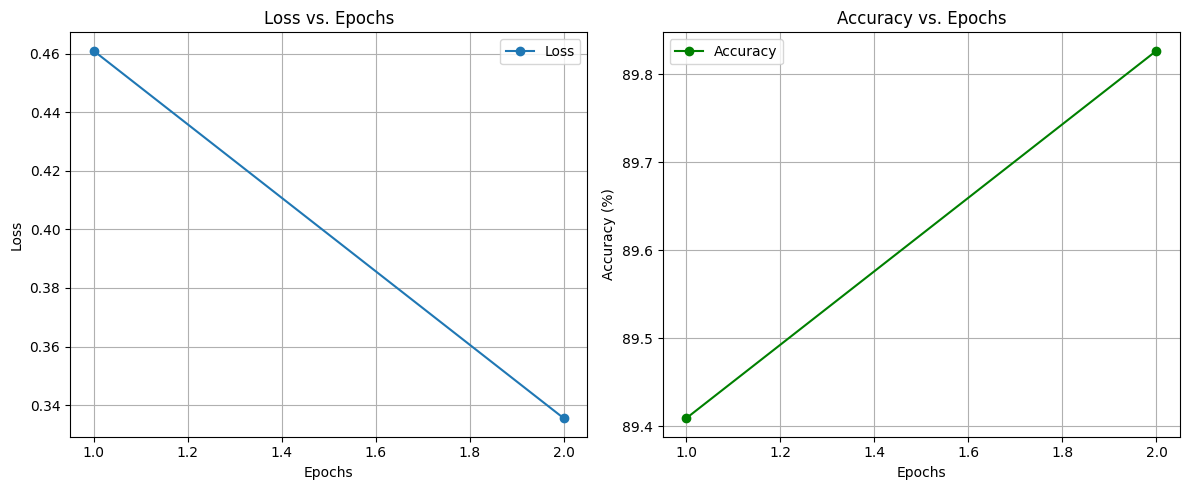

In [91]:
plot_results(best_history['train_loss'], best_history['train_accuracy'], 2)

In [97]:

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_accuracy = train_utils.evaluate_model(resnet18, test_loader, device)

In [100]:
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 89.83%
